 **Problem statement:**We have to built a classification model that would take a Chest X-Ray of a person and would predict whether the person is normal i.e healthy or has Viral or is COVID affected.


**Architecture:**

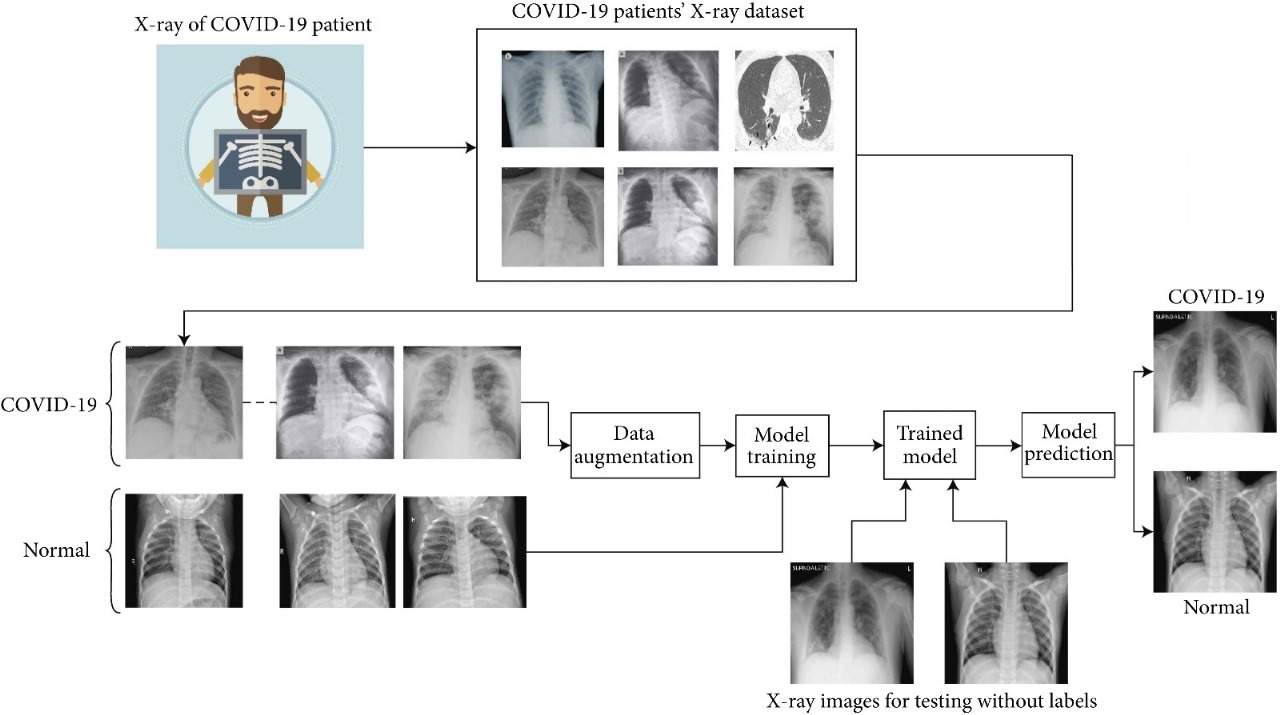







**Implementation steps:**
1. data acquisition by mounting google drive
2. Importing Libraries
3. Create a custom dataset class
4. Image data of fixed size
5. Loading data to the classes
6. Data exploration and visualization
7. Train the model
8. load and save the ResNet-18 model
9. Test the model
10. Evaluate the model
11. Deployment







**STEP-1:**Mount Your Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**STEP-2:**Importing libraries


In [ ]:
%matplotlib inline
#enables the display of Matplotlib graphics inline in a NOTEBOOK.
import os
#provides a way of using operating system dependent functionality like reading or writing to the file system.
import shutil
#provides a higher level interface for copying and moving files and directories.
import random
#provides various random number generators.
import torch
#imports the PyTorch library(used for applications such as computer vision and natural language processing).
import torchvision
#provides utilities for working with images and other data.
import numpy as np
# import NumPy library for working with arrays and matrices in Python.
from PIL import Image
# imports the Image class from the Python Imaging Library (PIL), which provides image processing capabilities.
from matplotlib import pyplot as plt
# Matplotlib is a library for creating static, animated, and interactive visualizations in Python.
torch.manual_seed(0)
#This ensures that the same random numbers are generated every time the code is run.
from torch.autograd import Variable
#The Variable class is used to represent data in PyTorch.
print('Using PyTorch version', torch.__version__)
#This line prints the version of PyTorch that is currently being used.
import pickle





Using PyTorch version 2.2.1+cu121


**Challenges:** No challenges faced while running this cell.

**STEP-3:** Here we create a Custom Dataset Class that is used to iterate through the dataset. This custom class inherits an abstract class Dataset and override  two important methods:
__len__ so that len(dataset) returns the size of the dataset.
__getitem__ to support the indexing such that dataset[i] can be used to get the ith sample

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
  #This line defines a new class called ChestXRayDataset that inherits from PyTorch's Dataset class.
    def __init__(self, image_dirs, transform):
      #This line defines the constructor for the ChestXRayDataset class.
        def get_images(class_name):
          # This line defines a nested function that returns a list of image file names for a given class name.
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            #This line gets a list of all the image files in the directory for the given class name.
            #It uses list comprehension to filter the list to only include files that end with '.png'.
            print(f'Found {len(images)} {class_name} examples')
            #This line prints the number of image files found for the given class name.
            return images
            #This line returns the list of image file names for the given class name.

        self.images = {}
        #This line initializes an empty dictionary called images that will be used to store the list of image.
        self.class_names = ['normal', 'viral', 'covid']
        #This line initializes a list of class names.

        for class_name in self.class_names:
          # This line starts a loop that iterates over the list of class names.
            self.images[class_name] = get_images(class_name)
            #This line gets a list of image file names for the current class name and stores it in the images dictionary.

        self.image_dirs = image_dirs
        #This line stores the image_dirs argument in an instance variable called image_dirs.
        self.transform = transform
        #This line stores the transform argument in an instance variable called transform.


    def __len__(self):
      #This line defines the __len__ method for the ChestXRayDataset class.
        return sum([len(self.images[class_name]) for class_name in self.class_names])
        #This line returns the total number of images in the dataset by summing the length of the list of image file
        # names for each class name.


    def __getitem__(self, index):
      #This line defines the __getitem__ method for the ChestXRayDataset class.
        class_name = random.choice(self.class_names)
        # This line randomly selects a class name.
        index = index % len(self.images[class_name])
        #This line wraps the index around the length of the list of image file names for the current class name.
        image_name = self.images[class_name][index]
        #This line gets the name of the image file at the current index for the current class name.
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        #This line constructs the full path to the image file
        image = Image.open(image_path).convert('RGB')
        #This line opens the image file and converts it to RGB format.
        return self.transform(image), self.class_names.index(class_name)
        # This line applies the transform argument to the image and returns the transformed image
        #and the index of the class name in the class_names list.

**Challenge:**FileNotFoundError


  All the images in my dataset has PNG type but i name with JPG,so i face error.

**Solution:** To remove this error i changed file type from JPG to PNG.

**STEP-4:**One encountered issue was that the samples were not of the same size. Most neural networks expect the images of a fixed size. Therefore, we perform some preprocessing over the train dataset as shown below.

In [ ]:
train_transform = torchvision.transforms.Compose([
    #defines a sequence of image transformations to be applied to the input images before they are fed into a PyTorch model.
    torchvision.transforms.Resize(size = (224,224)),
    #This transformation resizes the input image to have a size of 224x224 pixels.
    torchvision.transforms.RandomHorizontalFlip(),
    #This transformation randomly flips the input image horizontally with a probability of 0.5.
    torchvision.transforms.ToTensor(),
    # This transformation converts the input image from a PIL Image or numpy.ndarray to a PyTorch tensor.
    #It also scales the image's pixel intensity values in the range [0, 255] to floats in the range [0.0, 1.0].
    torchvision.transforms.Normalize(mean =[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    #- This transformation normalizes the input image by subtracting the mean and dividing by the standard deviation.
    #The mean and standard deviation values are typically calculated from the training dataset and are used to standardize the input data.
    #This helps to improve the model's convergence and performance.
])

**Challenge:** ModuleNotFoundError

**Solution:** While importing the libraries,i don't import the torchvision.So to remove this error i import torchvision library by import torchvision.

1.what do you mean by normalize?

Normalization refers to rescaling real-valued numeric attributes into a standard format. Data normalization is used in machine learning to make model training less sensitive to the scale of features.

2.what is random horizontal flip?

This transformation normalizes the input image by horizontally flipping the image.
This helps to improve the model's performance.

**STEP-5:**One encountered issue was that the samples were not of the same size. Most neural networks expect the images of a fixed size. Therefore, we perform some preprocessing over the test dataset as shown below.

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean =[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])

**Challenge:**No challenges are faced while running this code.

1.What is tensors in python?

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model's parameters.

**STEP-6:**  Here we create a dictionary with the keys as the different class names(normal, viral, and COVID), and the values to each key would be their corresponding directory in which the images of that class are stored. After that, we create 2 objects of the custom dataset class by passing the train dictionaries with their respective transform as parameters.The ChestXRayDataset class is likely a custom class that handles loading and processing of chest X-ray images for training a machine learning model.

In [ ]:
train_dirs = {
    'normal': '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images',
    'viral': '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'covid': '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images'
}

train_dataset = ChestXRayDataset(train_dirs,train_transform)

Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples


**Challenge:** FileNotFoundError

**Solution:**This code expect that the path of classes are correct and point to the directories where the images are located.Ensure the path of the files.

**STEP-7:** Here we create a dictionary with the keys as the different class names(normal, viral, and COVID), and the values to each key would be their corresponding directory in which the images of that class are stored. After that, we create 2 objects of the custom dataset class by passing the test dictionaries with their respective transform as parameters.The ChestXRayDataset class is likely a custom class that handles loading and processing of chest X-ray images for training a machine learning model.

In [ ]:
test_dirs = {
    'normal': '/content/drive/MyDrive/COVID-19_Radiography_Dataset/test/normal',
    'viral': '/content/drive/MyDrive/COVID-19_Radiography_Dataset/test/Viral Pnemonia',
    'covid': '/content/drive/MyDrive/COVID-19_Radiography_Dataset/test/covid'
}


test_dataset = ChestXRayDataset(test_dirs,test_transform)

Found 66 normal examples
Found 72 viral examples
Found 54 covid examples


**Challenge:** No challenges are faced while running this code.








**STEP-8:** In this step we pass the objects created in the step 6 and 7 named train_dataset and test_dataset to the dataloader with certain batch size. The purpose of the dataloader is to allow an easier implementation of chunk-reading and dynamic batch size.

In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2526
Number of test batches 32


**Challenge:** The batch size might not be optimal for the available memory or computational resources, leading to performance issues or memory errors.

**Solution:** Monitor memory usage and adjust the batch size accordingly to optimize resource utilization and prevent out-of-memory errors.

1.What is batch size.

Batch size refers to the number of training instances in the batch. For example, batch_size=6 means that there are 6 training instances in each batch.

2.What is dataloader?

dataloader iteratively loads data according to settings such as batch_size , shuffle etc.

3.What is suffle? why we use suffle.

Shuffling refers to the rearranging of elements in a random order which means no specific sequence is considered while arranging the elements.
                                                                    suffle ensure that the model is exposed to different patterns in each epoch.

**STEP-9:** In this step we perform data visualization.We create a function that would take the true labels, the predicted labels, and a set of images passed through a dataloader iterator, and display a set of images and if the prediction is correct i.e if the predicted label of the image matches with the true label of the image, then the predicted label would be displayed on the side of the image in green color and if the prediction is wrong, the predicted label would be displayed in red color.

In [ ]:
class_names = train_dataset.class_names
#This line retrieves the class names from the train_dataset object and assigns them to the class_names variable.
def show_images(images, labels, preds):
  #This line defines a function called show_images that takes three arguments: images, labels, and preds.
    plt.figure(figsize=(8, 4))
    #This line creates a new figure with a size of 8 inches wide and 4 inches tall.
    for i, image in enumerate(images):
      #This line starts a loop that iterates over the images array.
      #The enumerate function is used to get both the index i and the image for each iteration.
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        #This line creates a new subplot for the current image.
        #The subplot function is used to create a grid of subplots, with 1 row, 6 columns.
        image = image.numpy().transpose((1, 2, 0))
        #This line converts the current image from a tensor to a numpy array.
        mean = np.array([0.485, 0.456, 0.406])
        #This line defines the mean values for the RGB color channels. These values are used to normalize the pixel values of the image.
        std = np.array([0.229, 0.224, 0.225])
        #This line defines the standard deviation values for the RGB color channels.
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
#             print("label",labels[i])
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

**Challenge:** No error is faced while running this code.

What is enumerate used for?

Enumerate is a built-in function in python that allows you to keep track of the number of iterations in a loop.

**STEP-10:** In this step we iterate through the dataloader to pass on a batch of images and pass it to the function that we just created.

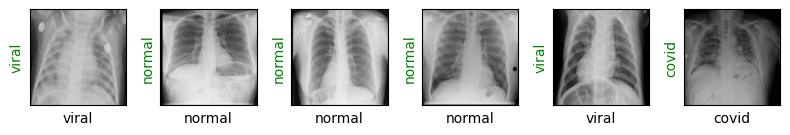

In [ ]:
images,labels = next(iter(dl_train))
show_images(images,labels,labels)

**Challenge:** NameError,due to not defining of show_image function.

**Solution:** Define the fuction named show_images.

**STEP-11:** Now i decided to go with a pre-trained model and then using transfer learning to solve the classification problem. The first name that came across my mind was Resnet18. And since I was using Pytorch, it was quite easy for me to get the resnet18 pre-trained model.

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Challenge:** No error is faced while running this code.

**STEP-12:** In this step we assign a CrossEntropy Loss to the model as it was the obvious choice for a classification task and use Adam as the optimizer with a learning rate of 4e-5.

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
#This line replaces the final fully-connected (FC) layer of the resnet18 model with a new FC layer,
# that has 512 input features and 3 output features.
loss_fn = torch.nn.CrossEntropyLoss()
#This line creates a new instance of the CrossEntropyLoss class from the torch.nn module and assigns it to the loss_fn variable.
optimizer = torch.optim.Adam(resnet18.parameters(), lr=4e-5)
#This line creates a new instance of the Adam optimizer from the torch.optim module and assigns it to the optimizer variable.

**Challenge:** The choice of optimizer and learning rate might not be suitable for the specific task or dataset, potentially leading to slow training.

**Solution:** Experiment with different optimizers (e.g., SGD, RMSprop) and learning rates to find the combination that results in faster convergence and better performance on the target task or dataset.

1.What is cross entropy loss?

Cross-entropy loss is a loss function used in classification tasks when training a supervised learning algorithm.

2.What is Adam optimizer?

Adaptive Moment Estimation is an algorithm for optimization used to minimize the loss function during training of neural networks. The method is really efficient when working with large problem involving a lot of data or parameters.
It has two parameters momentum” and “RMSprop” algorithms .Adam optimizer combines “gradient descent with momentum” and “RMSprop” algorithms. It gets the speed from “momentum” (gradient descent with momentum) and the ability to adapt gradients in different directions from RMSProp. The combination of the two makes it powerful

**STEP-13:** Now we create another function that would make predictions during training by iterating the dataloader and passing a batch of images to the modified ResNet model for prediction, and display the results using the function that we previously created.

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

**Challenge:** There is no error face while runing the code.

**STEP-14:** Here we create another function for the final part i.e the training of the model. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.


In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        train_loss = 0.
        val_loss = 0.
        resnet18.train() # set model to training phase
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                accuracy = 0
                resnet18.eval() # set model to eval phase
                for val_step, (images, labels) in enumerate(dl_test):
#                     print(type(images),images)
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)


                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                show_preds()
                resnet18.train()
                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    break
        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

**Challenge:** No error is faced while running the code.




1.What is epochs?

 epochs means one complete pass of the training dataset through the algorithm.

**STEP-15:** Now we call the train function py passing epochs=1:

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.4049, Accuracy: 0.3073


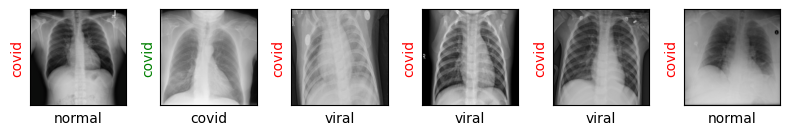

Evaluating at step 20
Validation Loss: 0.7973, Accuracy: 0.7135


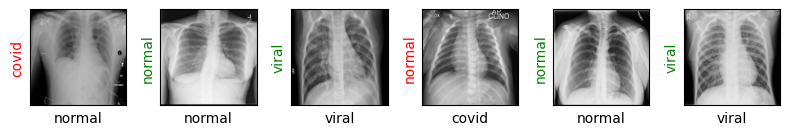

Evaluating at step 40
Validation Loss: 0.5682, Accuracy: 0.7917


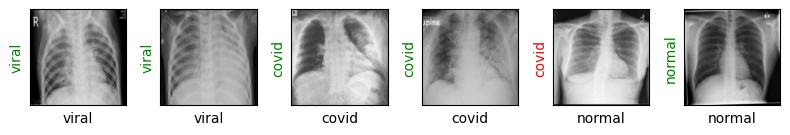

Evaluating at step 60
Validation Loss: 0.4148, Accuracy: 0.8594


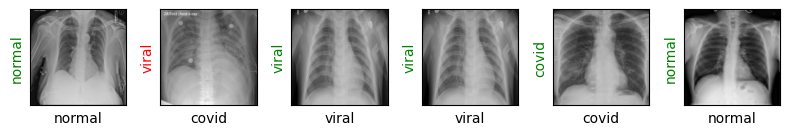

Evaluating at step 80
Validation Loss: 0.3352, Accuracy: 0.8958


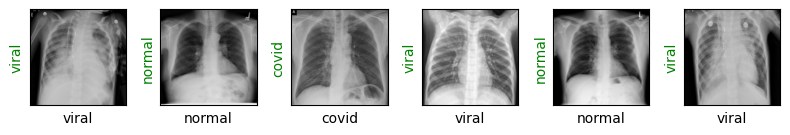

Evaluating at step 100
Validation Loss: 0.3559, Accuracy: 0.8854


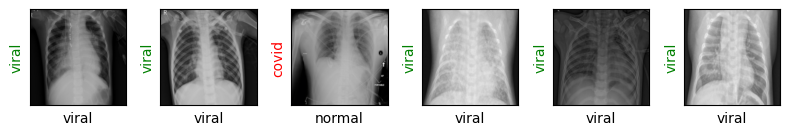

Evaluating at step 120
Validation Loss: 0.3905, Accuracy: 0.8802


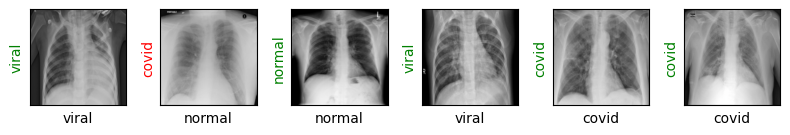

Evaluating at step 140
Validation Loss: 0.3170, Accuracy: 0.8802


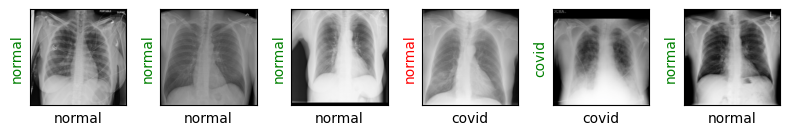

Evaluating at step 160
Validation Loss: 0.3453, Accuracy: 0.8906


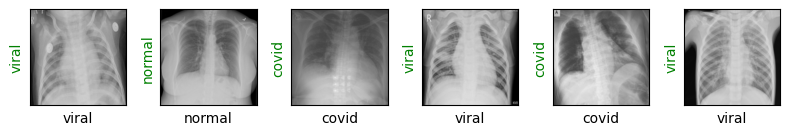

Evaluating at step 180
Validation Loss: 0.2938, Accuracy: 0.9219


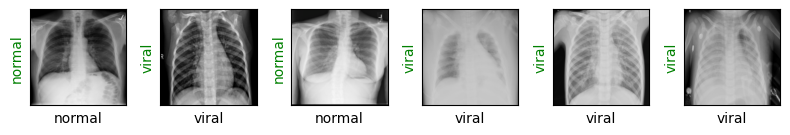

Evaluating at step 200
Validation Loss: 0.2583, Accuracy: 0.9375


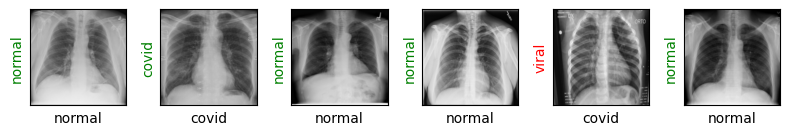

Evaluating at step 220
Validation Loss: 0.3375, Accuracy: 0.8958


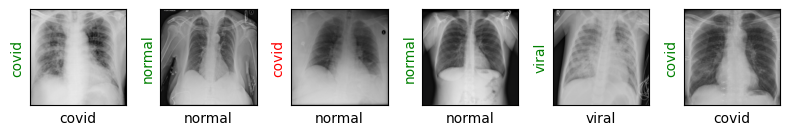

Evaluating at step 240
Validation Loss: 0.2686, Accuracy: 0.9375


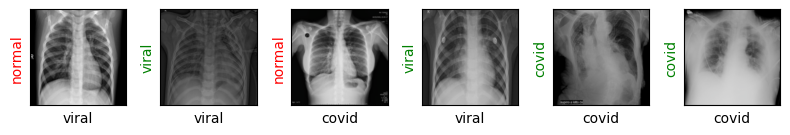

Evaluating at step 260
Validation Loss: 0.3379, Accuracy: 0.8854


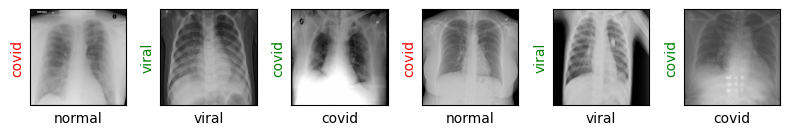

Evaluating at step 280
Validation Loss: 0.2622, Accuracy: 0.9167


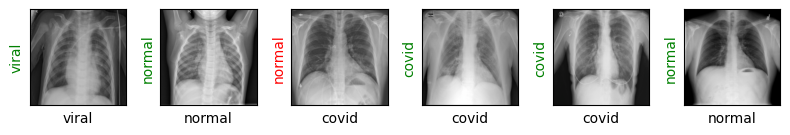

Evaluating at step 300
Validation Loss: 0.4912, Accuracy: 0.7969


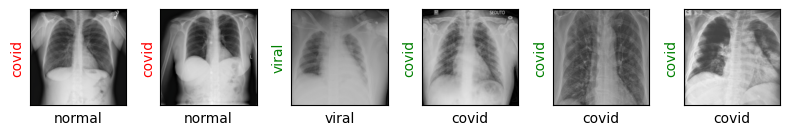

Evaluating at step 320
Validation Loss: 0.3571, Accuracy: 0.8646


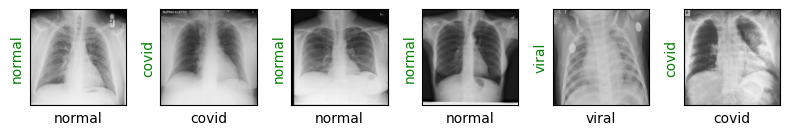

Evaluating at step 340
Validation Loss: 0.3836, Accuracy: 0.8802


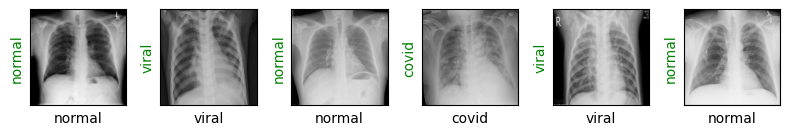

Evaluating at step 360
Validation Loss: 0.2466, Accuracy: 0.9167


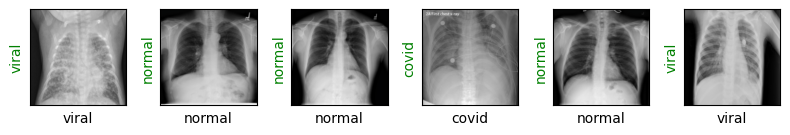

Evaluating at step 380
Validation Loss: 0.2190, Accuracy: 0.9323


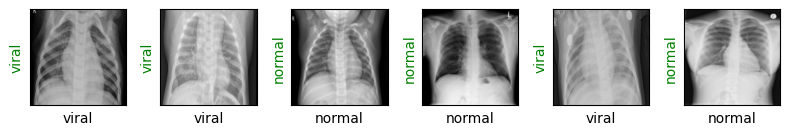

Evaluating at step 400
Validation Loss: 0.2548, Accuracy: 0.9479


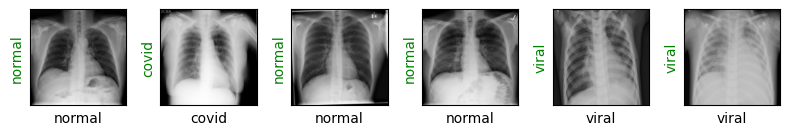

Evaluating at step 420
Validation Loss: 0.1793, Accuracy: 0.9375


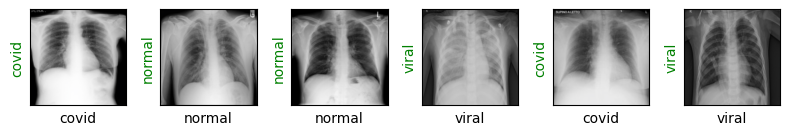

Evaluating at step 440
Validation Loss: 0.2134, Accuracy: 0.9010


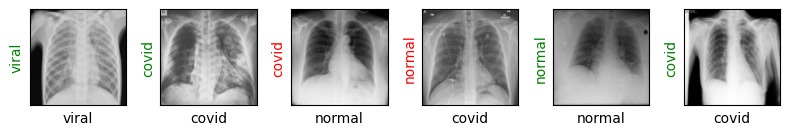

Evaluating at step 460
Validation Loss: 0.2444, Accuracy: 0.9167


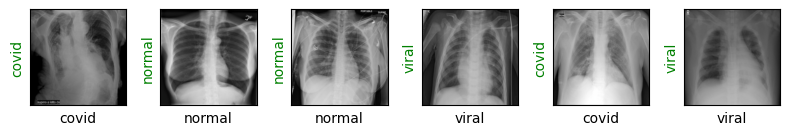

Evaluating at step 480
Validation Loss: 0.2507, Accuracy: 0.9115


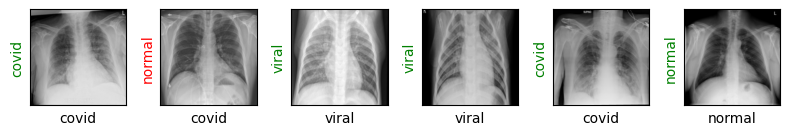

Evaluating at step 500
Validation Loss: 0.1651, Accuracy: 0.9531


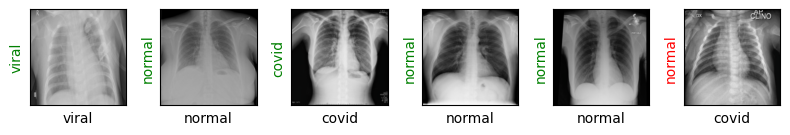

Performance condition satisfied, stopping..
Training Loss: 0.3508
Training complete..


In [ ]:
train(epochs=1)

**Challenge:** Training for  how many epoch will provide sufficient opportunity for the model to converge and learn optimal parameters.

**Solution:** passing different number of epoch for the training to get best output.








**STEP-16:** Till here the training is complete, and our model is now ready to be saved and tested.In this step we save our model.

**STEP-17:** In step-13 we created a function for predictions. Now is the perfect time to call it.
So in this step we call the function.

In [ ]:
torch.save(resnet18,'/content/drive/MyDrive/saved_model/covid.pkl')

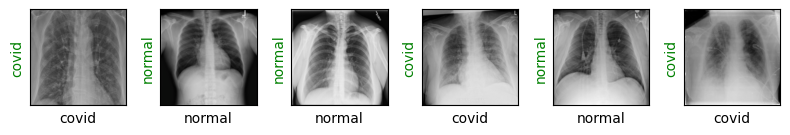

In [ ]:
show_preds()

**Challenge:** No error is faced while running the code.

**STEP-18:** In this step we load and evaluate our model.

In [ ]:
model = torch.load('/content/drive/MyDrive/saved_model/covid.pkl')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Challenge:** No error should be faced while load and evaluate the model.

**STEP-19:Predicting Class Label on a Single Image:**
Till now, we have trained our model on different batches of images. Now its time to test it on a single image input. To do that, we need to first transform the input, the same way we transformed the testing images. After that, we load the weights of the saved model, change the mode to evaluation, and pass the image as an input to produce an output tensor. Then, using a dictionary mapping, we return the predicted label.

In [ ]:
loader = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean =[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert('RGB')
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image
#pass the path of the image to be tested
image = image_loader('/content/drive/MyDrive/COVID-19_Radiography_Dataset/akash.png')
res_dict = {0:"Normal",1:"Viral",2:"Covid"}
output = model(image)
# print(output)
_, preds = torch.max(output, 1)
# print(preds)
print(res_dict[preds.tolist()[0]])

Covid


**Challenge:** The function image_loader assumes that the input image is always in RGB format, which may not be the case for all images, leading to errors during preprocessing.

**Solution:**Checks to ensure that the input image is properly formatted and compatible with the preprocessing steps, preventing potential errors during image loading and preprocessing.

what is required_grad?

We use  it to tell PyTorch that we want to calculate gradients with respect to that variable at that value.

what is overfitting?

when the model does not make accurate predictions on testing data. When a model gets trained with so much data, it starts learning from the noise and inaccurate data entries in our data set. And when testing with test data results in High variance. Then the model does not categorize the data correctly, because of too many details and noise.

What is underfitting?

When a model is too simple to capture data complexities. It represents the inability of the model to learn the training data effectively result in poor performance both on the training and testing data. In simple terms, an underfit model’s are inaccurate, especially when applied to new, unseen examples. It mainly happens when we uses very simple model with overly simplified assumptions